In [1]:
import gym
import MCTSnet
import copy
import torch

# Testing environment

In [2]:
env = gym.make("SokobanEnc-v0")

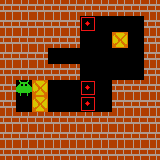

In [3]:
env.render()

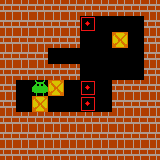

In [4]:
res = env.step(3)
env.render()

# Testing the four neural networks

In [5]:
e = MCTSnet.models.embedding.Epsilon()

In [6]:
state = torch.Tensor(res[0])
state.reshape((-1,4,10,10)).shape

torch.Size([1, 4, 10, 10])

In [7]:
embed = e.forward(state.reshape((-1, 4, 10, 10)))

In [8]:
reward = torch.tensor([res[1]], requires_grad=True)
action = torch.tensor([3.], requires_grad=True)

In [9]:
b = MCTSnet.models.backup.BetaMLP()

In [10]:
h_s = b(embed, embed, reward.reshape((-1, 1)), action.reshape((-1, 1)))

In [11]:
r = MCTSnet.models.readout.Rho()

In [12]:
r(h_s)

tensor([[0.1395, 0.1258, 0.1358, 0.1081, 0.1217, 0.1453, 0.1082, 0.1156]],
       grad_fn=<SoftmaxBackward>)

In [13]:
pi = MCTSnet.models.policy.Pi()
actions = pi(torch.cat((h_s, h_s, h_s, h_s, h_s, h_s, h_s, h_s, h_s), dim=0).reshape(-1, 9, 128))

In [14]:
actions

tensor([[0.1278, 0.1212, 0.1211, 0.1226, 0.1255, 0.1290, 0.1250, 0.1279]],
       grad_fn=<SoftmaxBackward>)

In [15]:
torch.argmax(actions)

tensor(5)

In [16]:
state.shape

torch.Size([4, 10, 10])

# Testing the full MCTSnet

In [17]:
m_net = MCTSnet.models.MCTSnet.MCTSnet(env, b, e, pi, r)
m_net.reset_tree(state.reshape((-1, 4, 10, 10)))
prediction = m_net(state.reshape((-1, 4, 10, 10)))

tensor(5)
tensor(5., grad_fn=<SumBackward0>)
tensor(7)
tensor(7., grad_fn=<SumBackward0>)
tensor(7)
tensor(7., grad_fn=<SumBackward0>)
tensor(5)
tensor(5., grad_fn=<SumBackward0>)
tensor(5)
tensor(5., grad_fn=<SumBackward0>)
tensor(5)
tensor(5., grad_fn=<SumBackward0>)
tensor(5)
tensor(5., grad_fn=<SumBackward0>)
tensor(7)
tensor(7., grad_fn=<SumBackward0>)
tensor(5)
tensor(5., grad_fn=<SumBackward0>)
tensor(7)
tensor(7., grad_fn=<SumBackward0>)
tensor(5)
tensor(5., grad_fn=<SumBackward0>)
tensor(5)
tensor(5., grad_fn=<SumBackward0>)
tensor(5)
tensor(5., grad_fn=<SumBackward0>)
tensor(5)
tensor(5., grad_fn=<SumBackward0>)
tensor(5)
tensor(5., grad_fn=<SumBackward0>)
tensor(5)
tensor(5., grad_fn=<SumBackward0>)
tensor(7)
tensor(7., grad_fn=<SumBackward0>)
tensor(5)
tensor(5., grad_fn=<SumBackward0>)
tensor(5)
tensor(5., grad_fn=<SumBackward0>)
tensor(7)
tensor(7., grad_fn=<SumBackward0>)
tensor(5)
tensor(5., grad_fn=<SumBackward0>)
tensor(5)
tensor(5., grad_fn=<SumBackward0>)
tensor(5)


F:\Projets\MCTSnet\MCTSnet\utils.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return torch.sum(torch.nn.functional.softmax(x * beta) * x_range)


In [18]:
prediction

tensor([[0.1404, 0.1175, 0.1346, 0.1084, 0.1249, 0.1618, 0.1085, 0.1040]],
       grad_fn=<SoftmaxBackward>)

In [19]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(m_net.parameters(), lr=0.0001)

### Checking that gradients are computed (is the model differentiable ?)

In [20]:
optimizer.zero_grad()
loss = criterion(prediction, torch.tensor([[1.,0.,0.,0.,0.,0.,0.,0.]]))
loss.backward()

In [21]:
m_net.backup.fc1.weight.grad

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -0.0000e+00,  0.0000e+00],
        [-4.6099e-06,  4.1199e-04,  6.6004e-05,  ...,  2.1650e-04,
         -2.6273e-04,  1.2540e-02],
        [ 0.0000e+00, -4.8464e-04, -8.8804e-06,  ...,  2.5041e-05,
          2.4390e-04, -1.2195e-02],
        ...,
        [ 0.0000e+00,  1.6143e-03,  3.7526e-04,  ...,  2.6592e-04,
         -1.0880e-03,  5.3754e-02],
        [-2.2211e-06, -1.4328e-03, -5.2177e-04,  ..., -3.8231e-04,
          1.1535e-03, -5.7754e-02],
        [ 2.6695e-06, -3.3431e-04, -1.0638e-04,  ..., -1.2037e-04,
          2.5411e-04, -1.1833e-02]])

In [22]:
m_net.embedding.input.weight.grad

tensor([[[[ 3.8092e-06,  1.1472e-05,  8.3684e-06],
          [ 3.6278e-06,  1.8923e-05,  5.9207e-06],
          [-1.8571e-06,  1.0023e-05,  1.7708e-06]],

         [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 1.8405e-06, -7.3025e-07,  0.0000e+00],
          [ 2.1297e-07,  0.0000e+00,  0.0000e+00]],

         [[-7.6444e-07,  0.0000e+00,  2.4012e-06],
          [ 1.2855e-07,  1.8405e-06, -7.3025e-07],
          [ 5.5491e-06, -3.9952e-07,  0.0000e+00]],

         [[ 0.0000e+00,  0.0000e+00,  1.8060e-06],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  3.0708e-06]]],


        [[[-1.0608e-05, -5.3875e-06, -1.4197e-05],
          [-5.8863e-06, -3.3623e-06, -3.5040e-06],
          [-3.5125e-06, -7.0617e-06, -2.5361e-06]],

         [[ 1.2106e-07, -1.1561e-06,  3.0534e-07],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00, -9.4701e-07]],

         [[-4.9088e-06,  8.9155e-07, -1.1707e-06],
          [ 3.717

as "expected" the policy doesn't learn and may require additionnal work

In [26]:
m_net.policy.piL.fc1.weight.grad.max()

tensor(0.)

In [24]:
m_net.readout.fc1.weight.grad

tensor([[-0.0000, -0.0171, -0.0034,  ..., -0.0170, -0.0026, -0.0023],
        [ 0.0000,  0.0023,  0.0005,  ...,  0.0023,  0.0004,  0.0003],
        [ 0.0000,  0.0027,  0.0005,  ...,  0.0027,  0.0004,  0.0004],
        ...,
        [ 0.0000,  0.0034,  0.0007,  ...,  0.0033,  0.0005,  0.0005],
        [ 0.0000,  0.0021,  0.0004,  ...,  0.0021,  0.0003,  0.0003],
        [ 0.0000,  0.0020,  0.0004,  ...,  0.0020,  0.0003,  0.0003]])

In [27]:
m_net.state_dict

<bound method Module.state_dict of MCTSnet(
  (backup): BetaMLP(
    (fc1): Linear(in_features=258, out_features=128, bias=True)
  )
  (embedding): Epsilon(
    (input): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (res3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (final): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
    (out): Linear(in_features=3200, out_features=128, bias=True)
  )
  (policy): Pi(
    (piL): PiLogits(
      (fc1): Linear(in_features=128, out_features=8, bias=True)
    )
    (piPL): PiPriorLogits(
      (input): Conv2d(9, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (res1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (res2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (final): Conv2d(32,